In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import albumentations as A
import albumentations.pytorch
import os
from tqdm import tqdm
import torchvision.transforms as T
from torchvision import models
torch.manual_seed(0)
import copy

## **Albumentations Transforms**

## **Torchvison Transforms**

In [2]:
def load_dataset(root:str,batch_size:int,train:bool,kwargs = None):
    transform = {"train": torchvision.transforms.Compose([T.GaussianBlur(kernel_size=(5,5)),
                                                           T.ColorJitter(contrast=0.2,brightness =  0.1,saturation=0.1),
                                                           T.Resize(size = (224,224)),
                                                         (T.ToTensor()),
                                                         (T.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)))]),
               
                 #construct a dictionary for preprocessing validation and testing images
                "val/test": torchvision.transforms.Compose([T.Resize(size =(224,224)),
                                                           (T.ToTensor()),
                                                           (T.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)))])}
    
    dataset = torchvision.datasets.ImageFolder(root,transform = transform["train" if train else "val/test"])
    
    dataloader = torch.utils.data.DataLoader(dataset,batch_size = batch_size,shuffle = True if train else False)
    
    return dataloader

In [3]:
training_root = "C:/Users/User/Desktop/stop signs detector/training" 
testing_root = "C:/Users/User/Desktop/stop signs detector/validation"

In [4]:
#load_dataset_(root = training_root,batch_size = 32,train = True)

In [5]:
train_dataloader = load_dataset(root = training_root,batch_size = 32,train = True)
val_dataloader = load_dataset(root = testing_root,batch_size = 32,train = False)

In [6]:
train_dataloader.dataset.class_to_idx

{'not_stop': 0, 'stop': 1}

In [7]:
train_dataloader.dataset.transforms

StandardTransform
Transform: Compose(
               GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
               ColorJitter(brightness=[0.9, 1.1], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=None)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [8]:
params = {"batch_size":32,
          "output_layer" : len(train_dataloader.dataset.classes),
          "momentum":0.01,
          "learning_rate":0.01,
          "base_lr":0.0001,
          "max_lr":0.1,
          "lr_scheduler":True}

If you set to <code>lr_scheduler=True</code>  for every epoch use a learning rate scheduler changes the range of the learning rate from a maximum or minimum value. The learning rate usually decays over time.

<h3 align = 'right'> we will be using torch.optim.lr_scheduler.CyclicLR() </h3>
<a href='https://arxiv.org/pdf/1506.01186.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01'>Cyclical Learning Rates</a>


In [9]:
sample = next(iter(train_dataloader))
img = np.array(np.transpose(sample[0],axes = [0,2,3,1]))

In [11]:
sample[0].shape

torch.Size([32, 3, 224, 224])

In [12]:
train_dataloader.dataset.imgs[2]

('C:/Users/User/Desktop/stop signs detector/training\\not_stop\\108.jpg', 0)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.70it/s]


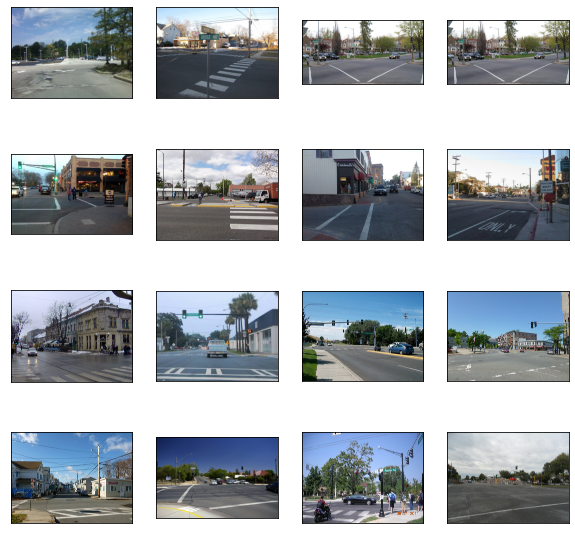

In [24]:
from PIL import Image
plt.figure(figsize=(10,10))
for i in tqdm(range(16)):
    plt.subplot(4,4,i+1)
    image = Image.open(train_dataloader.dataset.imgs[i][0])
    image = np.array(image)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    #plt.axes("off")

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 39.63it/s]


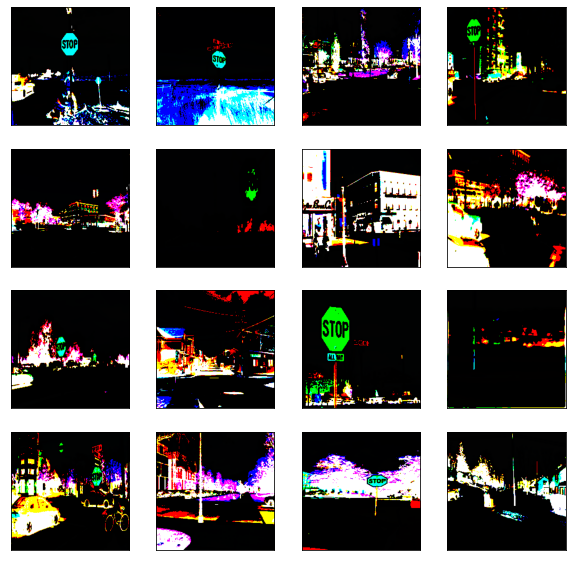

In [16]:
plt.figure(figsize=(10,10))
for i in tqdm(range(16)):
    plt.subplot(4,4,i+1)
    img = sample[0][i].numpy().squeeze().astype("uint8") #converting to unsigned 8 bit integer - image format
    #img = np.clip(sample[0][i].numpy().astype("uint8"),0,1)
   

    plt.imshow(np.transpose(img,[1,2,0]));        #img[i]
    plt.xticks([])
    plt.yticks([])

In [20]:
model = models.resnet18(pretrained = True, progress= True)

In [21]:
for i in model.parameters():
    i.requires_grad = False

from collections import OrderedDict
in_features = model.fc.out_features

# classifier = torch.nn.Sequential(OrderedDict([("classifier",torch.nn.Linear(in_features = model.fc.in_features,
#                                                                             out_features = params['output_layer']))]))
# model.fc = classifier

model.fc.add_module("relu",torch.nn.ReLU(inplace = True))
model.fc.add_module("fc2",torch.nn.Linear(in_features=in_features,out_features=params['output_layer']))

In [22]:
model.fc.requires_grad_(True)

Linear(
  in_features=512, out_features=1000, bias=True
  (relu): ReLU(inplace=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [24]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
def trainingLoop(model,dataloader,optimizer,criterion):
    
    model.train()
    
    acc = 0
    loss_ = 0
    
    for images,labels in dataloader:
        
        labels = labels.type(torch.int64)
        images = images.type(torch.float32)
        
        y_pred = model(images) # forward pass
        
#         print("shape of y_pred",y_pred.shape)
#         print("shape of labels",labels.shape)
#         break
        loss = criterion(y_pred,labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        acc+= (y_pred.argmax(1) == labels).sum().type(torch.FloatTensor).item()
        loss_+= loss
        
    __acc__ = acc/len(dataloader.dataset); __loss__ = loss_/len(dataloader)
    
    return model, __acc__, __loss__

In [26]:
def validationLoop(model,dataloader,criterion):
    model.eval()
    
    acc = 0
    loss = 0
    with torch.no_grad():
        for batch,(images,labels) in enumerate(dataloader):
    
            images,labels = images.to(device),labels.to(device)
            
            images = images.type(torch.float32)
            labels = labels.type(torch.int64)

            y_pred = model(images)

            loss+= criterion(y_pred,labels)
            acc+= (y_pred.argmax(1)==labels).sum().type(torch.FloatTensor).item()

        __acc__ = acc/len(dataloader.dataset); __loss__ = loss/len(dataloader)

    return __acc__,__loss__

In [27]:
optimizer = torch.optim.SGD(model.parameters(),lr = params['learning_rate'], momentum=params['momentum'])
criterion = torch.nn.CrossEntropyLoss()

params.update({"optimizer":optimizer})
params.update({"criterion":criterion})

In [28]:
params

{'batch_size': 32,
 'output_layer': 2,
 'momentum': 0.01,
 'learning_rate': 0.01,
 'base_lr': 0.0001,
 'max_lr': 0.1,
 'lr_scheduler': True,
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     momentum: 0.01
     nesterov: False
     weight_decay: 0
 ),
 'criterion': CrossEntropyLoss()}

In [32]:
def Epoch(model,params,num_epochs = 15,verbose = False,restart_scheduler = False):

    performance = {"__train_acc__":[], "__train_cost__":[],
                  "__val_acc__":[],"__val_cost__":[]}
    
    benchmark_accuracy = 0
    best_model_wts = None
    
    if restart_scheduler:
        if params['lr_scheduler']:

            params.update({"lr_scheduler":torch.optim.lr_scheduler.CyclicLR(optimizer= params['optimizer'],
                                                                            base_lr= params['base_lr'],
                                                                            max_lr= params['max_lr'],
                                                                            step_size_up = 5)})
    else:
        continue
        
    #construct a dictionary to store accuracies and loss of both training and evaluation
    
    for epochs in tqdm(torch.arange(num_epochs)):
        
        #Training Step
        trained_model,train_acc,train_loss = trainingLoop(model = model,dataloader = train_dataloader,optimizer=params['optimizer'],
                                                          criterion = params['criterion'])
#         import sys
#         sys.exit()
        params['lr_scheduler'].step()

        performance["__train_acc__"].append(train_acc)
        
        performance["__train_cost__"].append(train_loss.detach().numpy())
        
        # Validation Step
        val_acc,val_loss = validationLoop(model = trained_model,dataloader= val_dataloader,
                                          criterion= params['criterion'])
        
        performance["__val_acc__"].append(val_acc)
        performance["__val_cost__"].append(val_loss.detach().numpy())
        
        if val_acc >= benchmark_accuracy:
            best_model_wts = copy.deepcopy(model.state_dict())
            benchmark_accuracy = val_acc
            
        if verbose:

            print("Training Loss : {} >>> Validation Loss : {} >>> Validation Accuracy : {}".format(train_loss,val_loss,val_acc))
            
    print("Epochs Completed")
    
    model.load_state_dict(best_model_wts)    
    
    return model,performance,best_model_wts,benchmark_accuracy

SyntaxError: 'continue' not properly in loop (1586612176.py, line 17)

In [ ]:
params

In [ ]:
model,performance,best_model_wts,benchmark_accuracy = Epoch(model = model,num_epochs = 1,params = params,verbose= True)

In [ ]:
performance

In [ ]:
params

In [ ]:
def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "resnet18",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)    